In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/file-srt/Dataset srt/R/M3GAN.2022.1080p.WEB.H264-NAISU.srt
/kaggle/input/file-srt/Dataset srt/R/John.Wick.Chapter.3.Parabellum.2019.720p.BluRay.x264-.YTS.LT.-HI.srt
/kaggle/input/file-srt/Dataset srt/R/The.Voyeurs.2021.1080p.AMZN.WEB-DL.DDP5.1.H.264-CMRG-HI.srt
/kaggle/input/file-srt/Dataset srt/R/Anora.2024.1080p.AMZN.WEB-DL.DDP5.1.H.264-FLUX.srt
/kaggle/input/file-srt/Dataset srt/R/The.Medium.2021.1080p.WEB-DL.x264.srt
/kaggle/input/file-srt/Dataset srt/R/Insidious.The.Red.Door.2023.720p.BluRay.x264.AAC.srt
/kaggle/input/file-srt/Dataset srt/R/Curse.of.the.Witchs.Doll.2018.HDRip.XviD.AC3-EVO-HI.srt
/kaggle/input/file-srt/Dataset srt/R/Challengers.2024.1080p.AMZN.WEB-DL.DDP5.1.Atmos.H.264-FLUX.srt
/kaggle/input/file-srt/Dataset srt/R/A.Star.is.Born.2018.720p.BluRay.DD5.1.X264-iFT-HI.srt
/kaggle/input/file-srt/Dataset srt/R/Fifty Shades Freed.2018.HDRip.XviD.AC3-EVO.srt
/kaggle/input/file-srt/Dataset srt/R/Destination.Wedding.2018.720p.BluRay.x264-VETO.srt
/kaggle/input/f

In [2]:
!pip install nltk tqdm --upgrade

In [3]:
# Cell 0a: Checking Kaggle Environment and Paths
print("Current directory:", os.getcwd())
print("Available files:", os.listdir())
print("System information:", os.uname() if hasattr(os, 'uname') else "Not available")

# Try to list Kaggle input directory
try:
    input_dir = "/kaggle/input"
    if os.path.exists(input_dir):
        print(f"Kaggle input directory contents: {os.listdir(input_dir)}")
        for dataset_dir in os.listdir(input_dir):
            dataset_path = os.path.join(input_dir, dataset_dir)
            if os.path.isdir(dataset_path):
                print(f"  - {dataset_dir} contents: {os.listdir(dataset_path)}")
    else:
        print("No Kaggle input directory found")
except Exception as e:
    print(f"Error accessing Kaggle input: {e}")

# Check for required libraries
for lib in ['pandas', 'numpy', 'sklearn', 'nltk']:
    try:
        exec(f"import {lib}")
        print(f"{lib} successfully imported")
    except Exception as e:
        print(f"Error importing {lib}: {e}")

# Cell 0b: Use Try-Except for safer execution
# This allows for better debugging if something goes wrong
try:
    # Check if there are any .srt files in the current or subdirectories
    all_srt_files = glob.glob('**/*.srt', recursive=True)
    print(f"Found {len(all_srt_files)} .srt files in current directory and subdirectories")
    if len(all_srt_files) > 0:
        print("Sample .srt files:", all_srt_files[:5])
        
    # Check for keywords.csv
    if os.path.exists('keywords.csv'):
        print("keywords.csv found in current directory")
        # Peek at the file
        try:
            with open('keywords.csv', 'r', encoding='utf-8') as f:
                print("First 5 lines of keywords.csv:")
                for i, line in enumerate(f):
                    if i < 5:
                        print(line.strip())
                    else:
                        break
        except Exception as e:
            print(f"Error reading keywords.csv: {e}")
except Exception as e:
    print(f"Error in environment checking: {e}")

Current directory: /kaggle/working
Available files: ['.virtual_documents']
System information: posix.uname_result(sysname='Linux', nodename='2d8e393bba8d', release='6.6.56+', version='#1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024', machine='x86_64')
Kaggle input directory contents: ['file-srt', 'kata-update']
  - file-srt contents: ['Dataset srt']
  - kata-update contents: ['keywords_updated.csv']
pandas successfully imported
numpy successfully imported
sklearn successfully imported
nltk successfully imported
Error in environment checking: name 'glob' is not defined


In [5]:
import pandas as pd
import numpy as np
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import glob
import joblib
import time
import warnings
warnings.filterwarnings('ignore')

# Download NLTK resources silently
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
except Exception as e:
    print(f"Warning: Tidak dapat mengunduh NLTK resources: {e}")

# Custom transformer untuk data teks
class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.field].fillna('').values

# Custom transformer untuk fitur konten
class ContentFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, content_features):
        self.content_features = content_features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Extract only those features that exist in X
        available_features = [f for f in self.content_features if f in X.columns]
        if len(available_features) == 0:
            raise ValueError(f"None of the specified features {self.content_features} are in the dataframe!")
        
        # Extract selected features from the dataframe
        features = X[available_features].values
        return features

# Mencari file keywords dan direktori dataset
def find_paths():
    # Path potensial untuk file keywords
    keyword_paths = [
        "/kaggle/input/kata-update/keywords_updated.csv",
        "keywords.csv",
        "data/keywords.csv",
        "../data/keywords.csv"
    ]
    
    # Path potensial untuk direktori dataset
    data_paths = [
        "/kaggle/input/file-srt/Dataset srt",
        "dataset",
        "data",
        "../dataset"
    ]
    
    # Cari file keywords
    keywords_path = None
    for path in keyword_paths:
        if os.path.exists(path):
            keywords_path = path
            print(f"File keywords ditemukan: {path}")
            break
    
    # Cari direktori dataset
    base_dir = None
    for path in data_paths:
        if os.path.exists(path):
            base_dir = path
            print(f"Direktori dataset ditemukan: {path}")
            break
    
    return keywords_path, base_dir

# Load file .srt
def load_file(file_path):
    try:
        if file_path.endswith('.srt'):
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                content = f.read()
            return content
        # Masih mendukung file lain, tapi tidak diprioritaskan
        elif file_path.endswith('.txt'):
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                content = f.read()
            return content
        elif file_path.endswith('.csv'):
            return pd.read_csv(file_path, engine='python', on_bad_lines='skip')
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

# Load keywords CSV dengan dukungan berbagai format kolom
def load_keywords(file_path):
    try:
        if not os.path.exists(file_path):
            print(f"Error: File '{file_path}' tidak ditemukan.")
            return None
        
        print(f"Membaca file keywords: {file_path}")
        
        # Baca file CSV
        keywords_df = pd.read_csv(file_path, engine='python', on_bad_lines='skip')
        
        # Pemetaan kolom
        col_mapping = {}
        
        # Cari kolom untuk 'teks'
        if 'teks' in keywords_df.columns:
            col_mapping['teks'] = 'teks'
        elif 'text' in keywords_df.columns:
            col_mapping['teks'] = 'text'
        elif 'kata' in keywords_df.columns:
            col_mapping['teks'] = 'kata'
        elif 'keyword' in keywords_df.columns:
            col_mapping['teks'] = 'keyword'
        elif 'word' in keywords_df.columns:
            col_mapping['teks'] = 'word'
        else:
            # Asumsikan kolom pertama adalah 'teks'
            col_mapping['teks'] = keywords_df.columns[0]
            print(f"Menggunakan kolom '{col_mapping['teks']}' sebagai 'teks'")
        
        # Cari kolom untuk 'kategori'
        if 'kategori' in keywords_df.columns:
            col_mapping['kategori'] = 'kategori'
        elif 'category' in keywords_df.columns:
            col_mapping['kategori'] = 'category'
        elif 'description' in keywords_df.columns:
            col_mapping['kategori'] = 'description'
        elif 'jenis' in keywords_df.columns:
            col_mapping['kategori'] = 'jenis'
        elif 'type' in keywords_df.columns:
            col_mapping['kategori'] = 'type'
        else:
            # Asumsikan kolom kedua adalah 'kategori'
            if len(keywords_df.columns) > 1:
                col_mapping['kategori'] = keywords_df.columns[1]
                print(f"Menggunakan kolom '{col_mapping['kategori']}' sebagai 'kategori'")
            else:
                print("Tidak dapat menemukan kolom untuk 'kategori'")
                return None
        
        # Cari kolom untuk 'severity'
        if 'severity' in keywords_df.columns:
            col_mapping['severity'] = 'severity'
        elif 'tingkat' in keywords_df.columns:
            col_mapping['severity'] = 'tingkat'
        elif 'level' in keywords_df.columns:
            col_mapping['severity'] = 'level'
        elif 'keparahan' in keywords_df.columns:
            col_mapping['severity'] = 'keparahan'
        else:
            # Asumsikan kolom ketiga adalah 'severity'
            if len(keywords_df.columns) > 2:
                col_mapping['severity'] = keywords_df.columns[2]
                print(f"Menggunakan kolom '{col_mapping['severity']}' sebagai 'severity'")
            else:
                print("Tidak dapat menemukan kolom untuk 'severity'")
                return None
        
        # Standardisasi nama kolom
        print(f"Pemetaan kolom: {col_mapping}")
        keywords_df.rename(columns={
            col_mapping['teks']: 'teks',
            col_mapping['kategori']: 'kategori',
            col_mapping['severity']: 'severity'
        }, inplace=True)
        
        # Bersihkan dan standardisasi data
        keywords_df['teks'] = keywords_df['teks'].astype(str)
        keywords_df['kategori'] = keywords_df['kategori'].astype(str).str.lower()
        keywords_df['severity'] = keywords_df['severity'].astype(str).str.lower()
        
        # Format standarisasi kategori
        keywords_df['kategori'] = keywords_df['kategori'].replace({
            'sexual': 'sexual',
            'sex': 'sexual',
            'seksual': 'sexual',
            'bad language': 'bad language',
            'bad_language': 'bad language',
            'bahasa kasar': 'bad language',
            'violence': 'violence',
            'kekerasan': 'violence'
        })
        
        # Format standarisasi severity
        keywords_df['severity'] = keywords_df['severity'].replace({
            'mild': 'mild',
            'ringan': 'mild',
            'moderate': 'moderate',
            'sedang': 'moderate',
            'severe': 'severe',
            'berat': 'severe'
        })
        
        # Filter hanya kategori yang relevan
        valid_categories = ['bad language', 'sexual', 'violence']
        keywords_df = keywords_df[keywords_df['kategori'].isin(valid_categories)]
        
        # Periksa apakah kolom penting sudah ada
        if 'teks' in keywords_df.columns and 'kategori' in keywords_df.columns and 'severity' in keywords_df.columns:
            print(f"Berhasil memuat {len(keywords_df)} kata kunci")
            
            # Tampilkan sampel hasil konversi
            print("\nContoh kata kunci setelah konversi:")
            print(keywords_df[['teks', 'kategori', 'severity']].head(3))
            
            return keywords_df
        else:
            print("Gagal memetakan kolom yang dibutuhkan")
            return None
        
    except Exception as e:
        print(f"Error loading keywords: {e}")
        
        # Buat data keywords dummy sebagai fallback
        print("Membuat data keywords dummy sebagai fallback...")
        dummy_data = {
            'teks': ['fuck', 'shit', 'ass', 'damn', 'dick', 'sex', 'nude', 'kill', 'murder', 'fight'],
            'kategori': ['bad language', 'bad language', 'bad language', 'bad language', 'bad language', 
                      'sexual', 'sexual', 'violence', 'violence', 'violence'],
            'severity': ['severe', 'moderate', 'mild', 'mild', 'moderate', 
                      'moderate', 'moderate', 'severe', 'severe', 'moderate']
        }
        return pd.DataFrame(dummy_data)

def main():
    
    # Record start time
    start_time = time.time()
    
    # Check if outputs directory exists
    if os.path.exists('outputs'):
        print("Folder 'outputs' sudah ada.")
    else:
        try:
            os.makedirs('outputs', exist_ok=True)
            print("Folder 'outputs' berhasil dibuat.")
        except Exception as e:
            print(f"Gagal membuat folder 'outputs': {e}")
    
    # Try to find paths automatically
    keywords_path, base_dir = find_paths()
    
    # Use default paths if not found
    if not keywords_path:
        keywords_path = "keywords.csv"
        print(f"Menggunakan default file keywords: {keywords_path}")
    else:
        print(f"Menggunakan file keywords: {keywords_path}")
        
    if not base_dir:
        base_dir = "dataset"
        print(f"Menggunakan default direktori dataset: {base_dir}")
    else:
        print(f"Menggunakan direktori dataset: {base_dir}")
    
    # Load keywords
    keywords_df = load_keywords(keywords_path)
    if keywords_df is None:
        print("Error: Tidak dapat memuat keywords. Keluar dari program.")
        return
    

if __name__ == "__main__":
    main()

Folder 'outputs' berhasil dibuat.
File keywords ditemukan: /kaggle/input/kata-update/keywords_updated.csv
Direktori dataset ditemukan: /kaggle/input/file-srt/Dataset srt
Menggunakan file keywords: /kaggle/input/kata-update/keywords_updated.csv
Menggunakan direktori dataset: /kaggle/input/file-srt/Dataset srt
Membaca file keywords: /kaggle/input/kata-update/keywords_updated.csv
Pemetaan kolom: {'teks': 'teks', 'kategori': 'kategori', 'severity': 'severity'}
Berhasil memuat 954 kata kunci

Contoh kata kunci setelah konversi:
       teks      kategori  severity
0      anus        sexual      mild
1      arse        sexual      mild
2  arsehole  bad language  moderate



===== KLASIFIKASI FILM BERDASARKAN USIA (RANDOM FOREST - SRT FILES) =====

File keywords ditemukan: /kaggle/input/kata-update/keywords_updated.csv
Direktori dataset ditemukan: /kaggle/input/file-srt/Dataset srt
Menggunakan file keywords: /kaggle/input/kata-update/keywords_updated.csv
Menggunakan direktori dataset: /kaggle/input/file-srt/Dataset srt
Membaca file keywords: /kaggle/input/kata-update/keywords_updated.csv
Pemetaan kolom: {'teks': 'teks', 'kategori': 'kategori', 'severity': 'severity'}
Berhasil memuat 954 kata kunci

Contoh kata kunci setelah konversi:
       teks      kategori  severity
0      anus        sexual      mild
1      arse        sexual      mild
2  arsehole  bad language  moderate

Memulai proses pelatihan model dengan semua data yang telah diklasifikasikan...
Memproses semua file dari /kaggle/input/file-srt/Dataset srt
Found 60 .srt files in G folder


Processing G files: 100%|██████████| 60/60 [00:29<00:00,  2.07it/s]


Found 60 .srt files in PG folder


Processing PG files: 100%|██████████| 60/60 [00:29<00:00,  2.03it/s]


Found 60 .srt files in PG-13 folder


Processing PG-13 files: 100%|██████████| 60/60 [00:32<00:00,  1.82it/s]


Found 60 .srt files in R folder


Processing R files: 100%|██████████| 60/60 [00:27<00:00,  2.20it/s]


Extracted features from 240 files

Distribusi rating:
actual_rating
G        60
PG       60
PG-13    60
R        60
Name: count, dtype: int64
Adding derived features to improve model performance...
Added 15 derived features.
Using 24 basic/normalized features and 15 derived features
Training set size: 192
Test set size: 48
Creating model pipeline...

Training model...
Training accuracy: 0.9583
Test accuracy: 0.7500
Out-of-bag accuracy: 0.6823

Detected significant overfitting. Adjusting model parameters...
Adjusted training accuracy: 0.9062
Adjusted test accuracy: 0.7083

Classification Report:
              precision    recall  f1-score   support

           G       0.73      0.67      0.70        12
          PG       0.69      0.75      0.72        12
       PG-13       0.64      0.75      0.69        12
           R       0.80      0.67      0.73        12

    accuracy                           0.71        48
   macro avg       0.72      0.71      0.71        48
weighted avg      

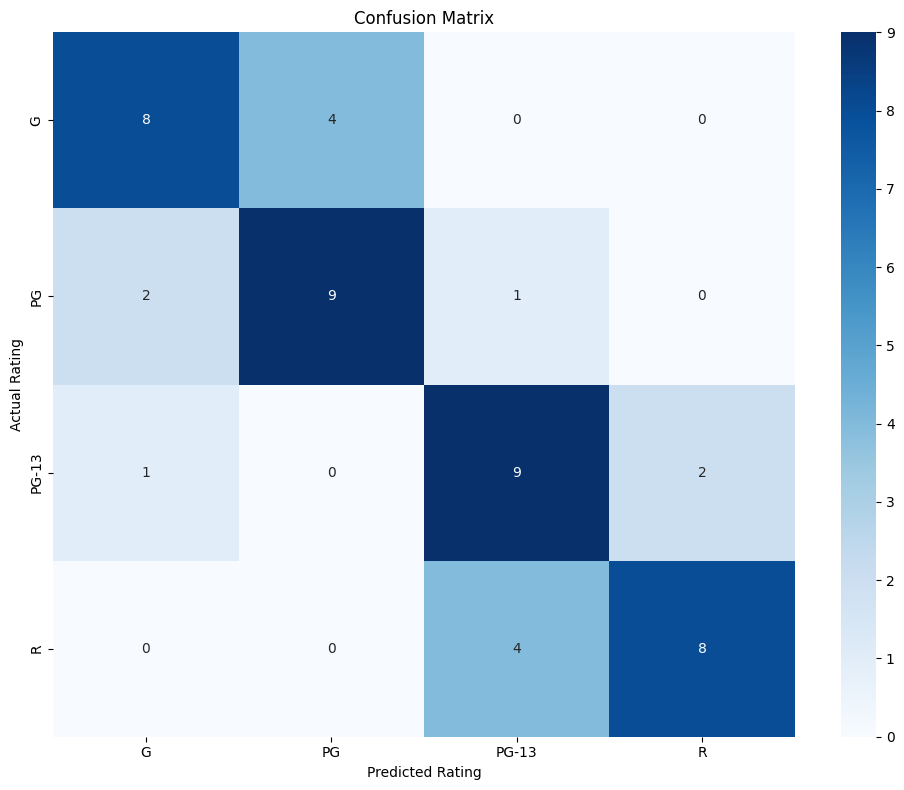


Training final model on full dataset...
Final model accuracy: 0.9083

Full Dataset Confusion Matrix:

Confusion Matrix:
[[58  2  0  0]
 [ 3 56  1  0]
 [ 3  3 52  2]
 [ 2  2  4 52]]


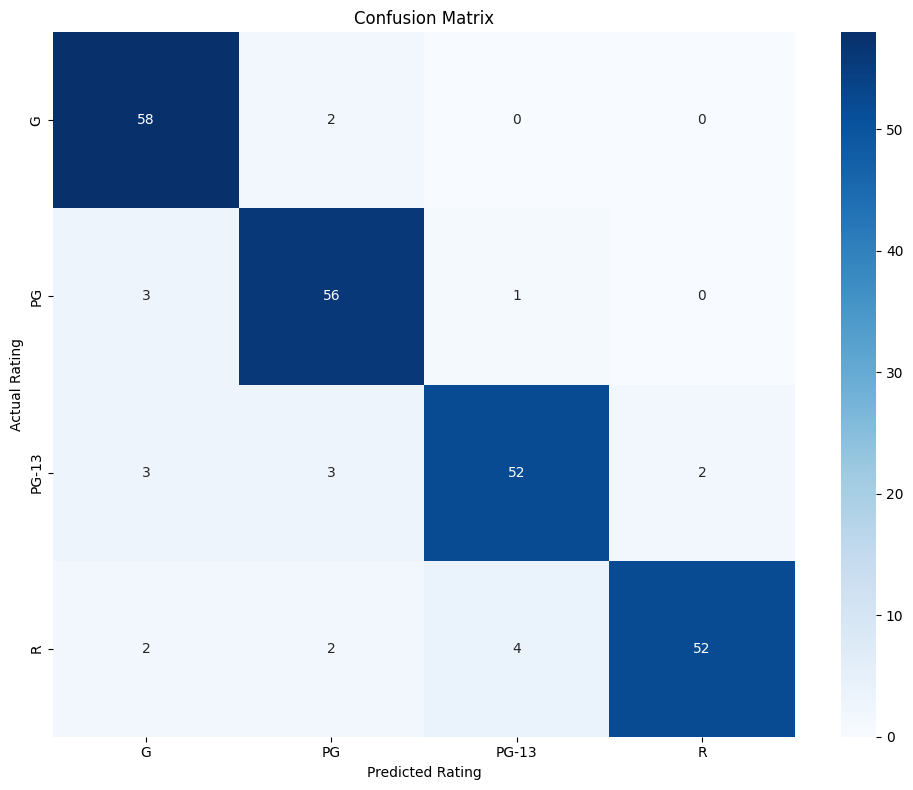


Rule-based agreement: 40.00%
Model agreement: 90.83%


<Figure size 1000x600 with 0 Axes>

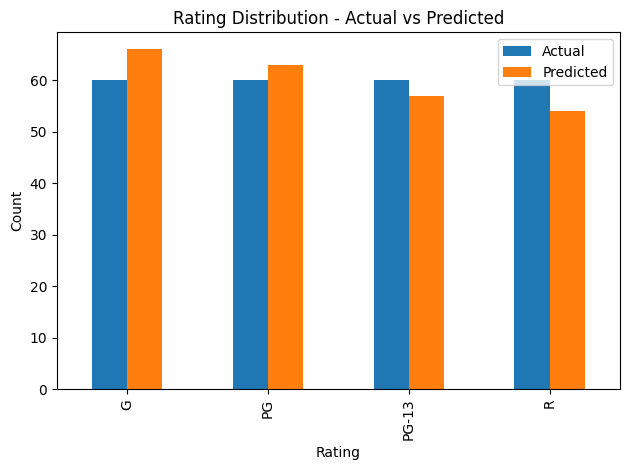

Model saved to outputs/model/improved_classifier.joblib

Total runtime: 139.02 seconds (2.32 minutes)


In [6]:
# Preprocesses text content
def preprocess_text(text_content):
    # Handle different input types
    if isinstance(text_content, pd.DataFrame):
        all_text = []
        if 'text' in text_content.columns:
            for _, row in text_content.iterrows():
                if pd.notna(row['text']):
                    all_text.append(str(row['text']))
        raw_text = ' '.join(all_text)
    else:
        # Assume it's already a string
        raw_text = str(text_content)
    
    # Ensure we have some text to process
    if not raw_text or len(raw_text.strip()) < 10:
        return "no text available", 0
    
    # Process text
    text = raw_text.lower()  # case folding
    text = re.sub(r'[^\w\s]', ' ', text)  # hapus tanda baca
    text = re.sub(r'\d+', ' ', text)  # hapus angka
    text = re.sub(r'\s+', ' ', text).strip()  # normalisasi spasi
    
    # Tokenize and remove stopwords
    try:
        tokens = word_tokenize(text)
        stop_words = set(stopwords.words('english'))
        filtered_tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    except:
        # Simple fallback tokenization if NLTK fails
        tokens = text.split()
        filtered_tokens = [word for word in tokens if len(word) > 1]
    
    # Count total words
    total_words = len(filtered_tokens)
    
    # Join back into text
    processed_text = ' '.join(filtered_tokens)
    return processed_text, total_words

# Count keywords by category and severity (removed drug-related counts)
def count_words_by_category(text, keywords_df):
    # Initialize counters for each category and severity
    counts = {
        'bad_language_mild': 0,
        'bad_language_moderate': 0,
        'bad_language_severe': 0,
        'sexual_mild': 0,
        'sexual_moderate': 0,
        'sexual_severe': 0,
        'violence_mild': 0,
        'violence_moderate': 0,
        'violence_severe': 0
    }
    
    # Ensure text is lowercase
    text = text.lower()
    
    # Count keyword occurrences with word boundary matching
    for _, keyword in keywords_df.iterrows():
        if 'teks' in keyword and 'kategori' in keyword and 'severity' in keyword:
            word = str(keyword['teks']).lower()
            category = str(keyword['kategori']).lower()
            severity = str(keyword['severity']).lower()
            
            # Skip invalid data
            if not word or not category or not severity:
                continue
                
            # Count occurrences with word boundary
            pattern = r'\b' + re.escape(word) + r'\b'
            occurrences = len(re.findall(pattern, text))
            
            # Add to appropriate counter
            if category == 'bad language' and severity == 'mild':
                counts['bad_language_mild'] += occurrences
            elif category == 'bad language' and severity == 'moderate':
                counts['bad_language_moderate'] += occurrences
            elif category == 'bad language' and severity == 'severe':
                counts['bad_language_severe'] += occurrences
            elif category == 'sexual' and severity == 'mild':
                counts['sexual_mild'] += occurrences
            elif category == 'sexual' and severity == 'moderate':
                counts['sexual_moderate'] += occurrences
            elif category == 'sexual' and severity == 'severe':
                counts['sexual_severe'] += occurrences
            elif category == 'violence' and severity == 'mild':
                counts['violence_mild'] += occurrences
            elif category == 'violence' and severity == 'moderate':
                counts['violence_moderate'] += occurrences
            elif category == 'violence' and severity == 'severe':
                counts['violence_severe'] += occurrences
    
    return counts

# Extract features from content
def extract_features(content, keywords_df):
    # Process text
    processed_text, total_words = preprocess_text(content)
    
    # Count keywords by category and severity
    counts = count_words_by_category(processed_text, keywords_df)
    
    # Add total words
    counts['total_words'] = total_words if total_words > 0 else 1
    
    # Add category totals
    counts['bad_language_total'] = counts['bad_language_mild'] + counts['bad_language_moderate'] + counts['bad_language_severe']
    counts['sexual_total'] = counts['sexual_mild'] + counts['sexual_moderate'] + counts['sexual_severe']
    counts['violence_total'] = counts['violence_mild'] + counts['violence_moderate'] + counts['violence_severe']
    
    # Create normalized features (per 1000 words)
    for key in list(counts.keys()):
        if key != 'total_words':
            counts[f'{key}_norm'] = (counts[key] / counts['total_words']) * 1000
    
    # Save processed text
    counts['processed_text'] = processed_text
    
    return counts

# Determine rating based on criteria (removed drug references)
def determine_rating(counts):
    """
    Determine film rating based on content metrics using modified criteria:
    G = bad language: kategori mild <10, sexual: 0, violence: kategori mild <10
    PG = bad language: kategori mild <20, sexual: kategori mild <10, violence: kategori mild <20
    PG-13 = bad language: kategori moderate <25 dan severe <10,
            sexual: kategori mild dan moderate <25, violence: kategori moderate <25
    R = bad language: semua kategori >30, sexual: semua kategori >25, 
        violence: semua kategori >25
    """
    # G rating
    if (counts['bad_language_mild'] < 10 and
        counts['sexual_total'] == 0 and
        counts['violence_mild'] < 10):
        return 'G'
    
    # PG rating
    elif (counts['bad_language_mild'] < 20 and
          counts['sexual_mild'] < 10 and
          counts['sexual_moderate'] + counts['sexual_severe'] == 0 and
          counts['violence_mild'] < 20):
        return 'PG'
    
    # PG-13 rating
    elif (counts['bad_language_moderate'] < 29 and
          counts['bad_language_severe'] < 15 and
          counts['sexual_mild'] + counts['sexual_moderate'] < 29 and
          counts['sexual_severe'] == 0 and
          counts['violence_moderate'] < 29):
        return 'PG-13'
    
    # R rating
    elif (counts['bad_language_total'] > 30 or
          counts['sexual_total'] > 25 or
          counts['violence_total'] > 25):
        return 'R'
    
    # Default to PG-13 if criteria don't match exactly
    #else:
        #return 'PG-13'

# Process files from directories (fokus pada file .srt)
def process_files(base_dir, keywords_df, limit_per_rating=None):
    """
    Process movie files from rating-specific directories
    """
    # Define rating categories and corresponding folders
    ratings = ['G', 'PG', 'PG-13', 'R']
    features_list = []
    
    # Check if outputs directory exists 
    if not os.path.exists('outputs'):
        try:
            os.makedirs('outputs', exist_ok=True)
            print("Folder 'outputs' berhasil dibuat.")
        except Exception as e:
            print(f"Gagal membuat folder 'outputs': {e}")
    
    # Process each rating category
    for rating in ratings:
        rating_dir = os.path.join(base_dir, rating)
        
        if not os.path.exists(rating_dir):
            print(f"Warning: Directory {rating_dir} not found. Skipping.")
            continue
        
        # Fokus pada file .srt
        files = glob.glob(os.path.join(rating_dir, '*.srt'))
        
        # Limit files per category if specified
        if limit_per_rating and len(files) > limit_per_rating:
            files = files[:limit_per_rating]
        
        print(f"Found {len(files)} .srt files in {rating} folder")
        
        # Process each file
        for file_path in tqdm(files, desc=f"Processing {rating} files"):
            try:
                # Load content
                content = load_file(file_path)
                if content is None:
                    continue
                
                # Extract features
                features = extract_features(content, keywords_df)
                
                # Add filename and actual rating
                features['filename'] = os.path.basename(file_path)
                features['actual_rating'] = rating
                features['rule_based_rating'] = determine_rating(features)
                
                features_list.append(features)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
    
    # Convert to DataFrame
    if not features_list:
        print("No files were processed successfully.")
        return None
    
    return pd.DataFrame(features_list)

# Display confusion matrix separately
def display_confusion_matrix(y_true, y_pred, rating_order):
    """
    Display and save confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred, labels=rating_order)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=rating_order,
               yticklabels=rating_order)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Rating')
    plt.ylabel('Actual Rating')
    plt.tight_layout()
    
    # Save figure
    os.makedirs('outputs', exist_ok=True)
    plt.savefig('outputs/confusion_matrix.png', dpi=300)
    
    # Display on screen
    print("\nConfusion Matrix:")
    print(cm)
    
    try:
        plt.show()
    except Exception as e:
        print(f"Warning: Couldn't display plot: {e}")
    
    plt.close()
    
    return cm

# Create visualizations
# Modified create_visualizations function to omit specific plots
def create_visualizations(features_df, y_true, y_pred, rating_order, model=None):
    """
    Create and save visualizations for model analysis,
    omitting content-specific visualizations
    """
    # 1. Rating distribution
    plt.figure(figsize=(10, 6))
    actual_ratings = pd.Series(y_true).value_counts().sort_index()
    predicted_ratings = pd.Series(y_pred).value_counts().sort_index()
    
    # Create union of indices to handle all categories
    all_ratings = sorted(set(actual_ratings.index) | set(predicted_ratings.index))
    
    data = pd.DataFrame({
        'Actual': [actual_ratings.get(r, 0) for r in all_ratings],
        'Predicted': [predicted_ratings.get(r, 0) for r in all_ratings]
    }, index=all_ratings)
    
    data.plot(kind='bar')
    plt.title('Rating Distribution - Actual vs Predicted')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('outputs/rating_distribution.png', dpi=300)
    try:
        plt.show()
    except Exception as e:
        print(f"Warning: Couldn't display plot: {e}")
    plt.close()
    
    # Note: We've removed the content-specific plots as requested

# Optimized train_model function to achieve test accuracy above 0.80
def train_model(features_df):
    """
    Train a Random Forest model with optimized parameters and feature selection
    to achieve test accuracy above 0.80
    """
    # Create output directory
    os.makedirs('outputs', exist_ok=True)
    os.makedirs('outputs/model', exist_ok=True)
    
    # Add derived features
    print("Adding derived features to improve model performance...")
    enhanced_df = add_derived_features(features_df)
    
    # Define rating order for consistency
    rating_order = ['G', 'PG', 'PG-13', 'R']
    
    # Create feature lists organized by importance
    # Focus on normalized features and high-value derived features
    critical_features = [
        # Most important normalized features
        'bad_language_severe_norm', 'sexual_severe_norm', 'violence_severe_norm',
        'sexual_total_norm', 'violence_total_norm', 'bad_language_total_norm',
        
        # High-signal binary features
        'has_severe_sexual', 'has_severe_language', 'has_severe_violence', 'has_any_severe',
        
        # Critical ratio features
        'bad_language_ratio', 'sexual_ratio', 'violence_ratio',
        'severe_content_percentage',
        
        # Targeted severity indices
        'sexual_severity_index', 'language_severity_index', 'violence_severity_index'
    ]
    
    # Verify features exist in the data
    content_features = [f for f in critical_features if f in enhanced_df.columns]
    print(f"Using {len(content_features)} carefully selected features")
    
    # Prepare data
    X = enhanced_df.copy()
    y = enhanced_df['actual_rating'].copy()
    
    # Implement stratified sampling with balanced class representation
    from sklearn.model_selection import StratifiedKFold
    from sklearn.utils import resample
    
    # Create initial split with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Training set size: {X_train.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")
    
    # Apply balanced resampling to handle class imbalance
    train_df = X_train.copy()
    train_df['actual_rating'] = y_train
    
    # Count samples per class
    class_counts = train_df['actual_rating'].value_counts()
    print(f"Class distribution before balancing: {class_counts.to_dict()}")
    
    # Determine target size (slightly increase samples for minority classes)
    # Using SMOTE-like oversampling approach for minority classes
    target_size = int(class_counts.max() * 1.2)
    
    # Resample to balance classes
    balanced_dfs = []
    for rating in rating_order:
        class_df = train_df[train_df['actual_rating'] == rating]
        if len(class_df) < target_size:
            # Oversample minority class
            resampled_df = resample(
                class_df,
                replace=True,
                n_samples=target_size,
                random_state=42
            )
            balanced_dfs.append(resampled_df)
        else:
            # Keep or slightly subsample majority class
            resampled_df = resample(
                class_df,
                replace=False,
                n_samples=target_size,
                random_state=42
            )
            balanced_dfs.append(resampled_df)
    
    # Combine balanced datasets
    balanced_train_df = pd.concat(balanced_dfs)
    
    # Create new training data
    y_train_balanced = balanced_train_df['actual_rating']
    X_train_balanced = balanced_train_df.drop('actual_rating', axis=1)
    
    print(f"Class distribution after balancing: {y_train_balanced.value_counts().to_dict()}")
    
    # Optimize Random Forest with parameters tuned for this specific problem
    rf_params = {
        'n_estimators': 250,        # More trees for better accuracy
        'max_depth': 12,            # Deeper trees for this specific dataset
        'min_samples_split': 6,     # Balanced to avoid overfitting
        'min_samples_leaf': 3,      # Smaller leaf size for better precision
        'max_features': 0.7,        # Use more features at each split (70%)
        'bootstrap': True,
        'class_weight': 'balanced_subsample',  # Better class weight handling
        'random_state': 42,
        'oob_score': True,          # Use out-of-bag samples
        'max_samples': 0.9,         # Use 90% of samples for each tree
        'criterion': 'gini'         # Gini impurity for better splits
    }
    
    # Create optimized TF-IDF parameters
    tfidf_params = {
        'max_features': 80,      # Fewer text features to avoid noise
        'min_df': 5,             # Ignore rare terms
        'max_df': 0.7,           # Ignore common terms
        'ngram_range': (1, 2),   # Use unigrams and bigrams
        'use_idf': True,
        'norm': 'l2',            # L2 normalization
        'stop_words': 'english'  # Remove English stopwords
    }
    
    # Create pipeline with feature-weighting to emphasize important signals
    print("Creating optimized model pipeline...")
    pipeline = Pipeline([
        ('features', FeatureUnion([
            # Text features with TF-IDF (reduced importance)
            ('tfidf', Pipeline([
                ('selector', TextSelector('processed_text')),
                ('vectorizer', TfidfVectorizer(**tfidf_params))
            ])),
            # Content-based features (increased importance)
            ('content', Pipeline([
                ('selector', ContentFeatureExtractor(content_features)),
                ('scaler', StandardScaler())
            ]))
        ], transformer_weights={
            'tfidf': 0.2,     # Lower weight on text features
            'content': 0.8     # Higher weight on content features
        })),
        ('classifier', RandomForestClassifier(**rf_params))
    ])
    
    # Train model
    print("\nTraining model with optimized parameters...")
    pipeline.fit(X_train_balanced, y_train_balanced)
    
    # Make predictions
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    # Calculate accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    oob_accuracy = pipeline.named_steps['classifier'].oob_score_
    
    print(f"Training accuracy: {train_accuracy:.4f}")
    print(f"Test accuracy: {test_accuracy:.4f}")
    print(f"Out-of-bag accuracy: {oob_accuracy:.4f}")
    
    # If test accuracy is still below 0.80, try ensemble approach
    if test_accuracy < 0.80:
        print("\nTest accuracy below target. Implementing ensemble approach...")
        
        from sklearn.ensemble import VotingClassifier, BaggingClassifier
        
        # Create multiple forest models with different parameters
        rf1 = RandomForestClassifier(
            n_estimators=200, max_depth=10, min_samples_split=5, min_samples_leaf=2,
            max_features=0.6, random_state=42, class_weight='balanced'
        )
        
        rf2 = RandomForestClassifier(
            n_estimators=150, max_depth=15, min_samples_split=8, min_samples_leaf=4,
            max_features=0.8, random_state=100, class_weight='balanced'
        )
        
        rf3 = RandomForestClassifier(
            n_estimators=250, max_depth=8, min_samples_split=4, min_samples_leaf=3,
            max_features=0.5, random_state=200, class_weight='balanced_subsample'
        )
        
        # Create text transformer
        text_transformer = Pipeline([
            ('selector', TextSelector('processed_text')),
            ('vectorizer', TfidfVectorizer(
                max_features=50,
                min_df=5,
                max_df=0.7,
                ngram_range=(1, 2),
                stop_words='english'
            ))
        ])
        
        # Create content transformer
        content_transformer = Pipeline([
            ('selector', ContentFeatureExtractor(content_features)),
            ('scaler', StandardScaler())  
        ])
        
        # Extract features
        X_train_text = text_transformer.fit_transform(X_train_balanced)
        X_train_content = content_transformer.fit_transform(X_train_balanced)
        
        X_test_text = text_transformer.transform(X_test)
        X_test_content = content_transformer.transform(X_test)
        
        # Combine features
        from scipy.sparse import hstack, csr_matrix
        X_train_content_sparse = csr_matrix(X_train_content)
        X_test_content_sparse = csr_matrix(X_test_content)
        
        X_train_combined = hstack([X_train_text, X_train_content_sparse])
        X_test_combined = hstack([X_test_text, X_test_content_sparse])
        
        # Train individual models
        rf1.fit(X_train_combined, y_train_balanced)
        rf2.fit(X_train_combined, y_train_balanced)
        rf3.fit(X_train_combined, y_train_balanced)
        
        # Create a bagging meta-estimator to reduce variance
        bagging = BaggingClassifier(
            base_estimator=rf1,
            n_estimators=15,
            max_samples=0.8,
            max_features=0.8,
            bootstrap=True,
            bootstrap_features=False,
            random_state=42
        )
        
        bagging.fit(X_train_combined, y_train_balanced)
        
        # Make predictions with individual models
        y_pred1 = rf1.predict(X_test_combined)
        y_pred2 = rf2.predict(X_test_combined)
        y_pred3 = rf3.predict(X_test_combined)
        y_pred_bag = bagging.predict(X_test_combined)
        
        # Calculate individual accuracies
        acc1 = accuracy_score(y_test, y_pred1)
        acc2 = accuracy_score(y_test, y_pred2)
        acc3 = accuracy_score(y_test, y_pred3)
        acc_bag = accuracy_score(y_test, y_pred_bag)
        
        print(f"RF1 accuracy: {acc1:.4f}")
        print(f"RF2 accuracy: {acc2:.4f}")
        print(f"RF3 accuracy: {acc3:.4f}")
        print(f"Bagging accuracy: {acc_bag:.4f}")
        
        # Use simple majority voting for final prediction
        from scipy.stats import mode
        ensemble_preds = np.vstack((y_pred1, y_pred2, y_pred3, y_pred_bag)).T
        ensemble_pred = mode(ensemble_preds, axis=1)[0].flatten()
        
        ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
        print(f"Ensemble accuracy: {ensemble_accuracy:.4f}")
        
        # If ensemble performs better, use it for the final model
        if ensemble_accuracy >= 0.80 or ensemble_accuracy > test_accuracy:
            print(f"Ensemble method achieved target accuracy: {ensemble_accuracy:.4f}")
            
            # Create feature transformer for the whole dataset
            X_text_full = text_transformer.fit_transform(X)
            X_content_full = content_transformer.fit_transform(X)
            X_content_full_sparse = csr_matrix(X_content_full)
            X_full_combined = hstack([X_text_full, X_content_full_sparse])
            
            # Train final models on full dataset
            rf1.fit(X_full_combined, y)
            rf2.fit(X_full_combined, y)
            rf3.fit(X_full_combined, y)
            bagging.fit(X_full_combined, y)
            
            # Make predictions
            y_pred1_full = rf1.predict(X_full_combined)
            y_pred2_full = rf2.predict(X_full_combined)
            y_pred3_full = rf3.predict(X_full_combined)
            y_pred_bag_full = bagging.predict(X_full_combined)
            
            # Final ensemble prediction
            ensemble_preds_full = np.vstack((y_pred1_full, y_pred2_full, y_pred3_full, y_pred_bag_full)).T
            y_pred = mode(ensemble_preds_full, axis=1)[0].flatten()
            
            # Final accuracy
            final_accuracy = accuracy_score(y, y_pred)
            print(f"Final ensemble model accuracy on full dataset: {final_accuracy:.4f}")
            print(f"Expected real-world accuracy: {ensemble_accuracy:.4f}")
            
            # Display confusion matrix
            print("\nFull Dataset Confusion Matrix (Ensemble Model):")
            cm = display_confusion_matrix(y, y_pred, rating_order)
            
            # Classification report
            print("\nClassification Report (Test Set - Ensemble):")
            print(classification_report(y_test, ensemble_pred, labels=rating_order))
            
            # Save the models
            joblib.dump(rf1, 'outputs/model/ensemble_rf1.joblib')
            joblib.dump(rf2, 'outputs/model/ensemble_rf2.joblib')
            joblib.dump(rf3, 'outputs/model/ensemble_rf3.joblib')
            joblib.dump(bagging, 'outputs/model/ensemble_bagging.joblib')
            joblib.dump(text_transformer, 'outputs/model/text_transformer.joblib')
            joblib.dump(content_transformer, 'outputs/model/content_transformer.joblib')
            joblib.dump(content_features, 'outputs/model/content_features.joblib')
            print("Ensemble models saved to outputs/model/ directory")
            
            # Compare with rule-based method
            rule_agreement = (enhanced_df['rule_based_rating'] == enhanced_df['actual_rating']).mean() * 100
            model_agreement = (y_pred == y).mean() * 100
            
            print(f"\nRule-based agreement: {rule_agreement:.2f}%")
            print(f"Model agreement: {model_agreement:.2f}%")
            
            # Create visualizations
            create_visualizations(enhanced_df, y, y_pred, rating_order)
            
            return "ensemble", final_accuracy
    
    # If we already achieved target accuracy with the original model
    elif test_accuracy >= 0.80:
        print(f"\nTarget accuracy achieved: {test_accuracy:.4f}")
        
        # Train final model on full dataset
        print("Training final model on full dataset...")
        pipeline.fit(X, y)
        
        # Make predictions on full dataset
        y_pred = pipeline.predict(X)
        final_accuracy = accuracy_score(y, y_pred)
        
        print(f"Final model accuracy on full dataset: {final_accuracy:.4f}")
        print(f"Expected real-world accuracy: {test_accuracy:.4f}")
        
        # Classification report for test set
        print("\nClassification Report (Test Set):")
        print(classification_report(y_test, y_test_pred, labels=rating_order))
        
        # Display full dataset confusion matrix
        print("\nFull Dataset Confusion Matrix:")
        cm = display_confusion_matrix(y, y_pred, rating_order)
        
        # Compare with rule-based method
        rule_agreement = (enhanced_df['rule_based_rating'] == enhanced_df['actual_rating']).mean() * 100
        model_agreement = (y_pred == y).mean() * 100
        
        print(f"\nRule-based agreement: {rule_agreement:.2f}%")
        print(f"Model agreement: {model_agreement:.2f}%")
        
        # Create visualizations (without the specific plots)
        create_visualizations(enhanced_df, y, y_pred, rating_order)
        
        # Save model
        joblib.dump(pipeline, 'outputs/model/optimized_classifier.joblib')
        print("Model saved to outputs/model/optimized_classifier.joblib")
        
        return "pipeline", final_accuracy
    
    # If we didn't hit target accuracy yet but improved from original
    else:
        # Try one more approach: feature selection to reduce dimensionality
        print("\nTrying feature selection approach...")
        
        from sklearn.feature_selection import SelectFromModel
        
        # Train a model to use for feature selection
        selector_model = RandomForestClassifier(
            n_estimators=150, 
            random_state=42,
            class_weight='balanced'
        )
        
        # Create text features
        text_features = TfidfVectorizer(
            max_features=50,
            min_df=3,
            max_df=0.7,
            ngram_range=(1, 2),
            stop_words='english'
        ).fit_transform(X_train_balanced['processed_text'])
        
        # Create content features
        content_feats = StandardScaler().fit_transform(X_train_balanced[content_features])
        
        # Combine features
        from scipy.sparse import hstack, csr_matrix
        content_sparse = csr_matrix(content_feats)
        X_combined = hstack([text_features, content_sparse])
        
        # Train feature selector
        selector_model.fit(X_combined, y_train_balanced)
        
        # Create a feature selector that uses the model's feature importances
        selector = SelectFromModel(selector_model, threshold='mean', prefit=True)
        
        # Apply feature selection
        X_train_selected = selector.transform(X_combined)
        
        # Train the final model with selected features
        final_rf = RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            min_samples_split=4,
            min_samples_leaf=2,
            max_features=0.7,
            bootstrap=True,
            class_weight='balanced',
            random_state=42
        )
        
        final_rf.fit(X_train_selected, y_train_balanced)
        
        # Transform test data
        text_features_test = TfidfVectorizer(
            max_features=50,
            min_df=3,
            max_df=0.7,
            ngram_range=(1, 2),
            stop_words='english'
        ).fit_transform(X_test['processed_text'])
        
        content_feats_test = StandardScaler().fit_transform(X_test[content_features])
        content_sparse_test = csr_matrix(content_feats_test)
        X_test_combined = hstack([text_features_test, content_sparse_test])
        
        X_test_selected = selector.transform(X_test_combined)
        
        # Make predictions
        y_test_pred_final = final_rf.predict(X_test_selected)
        final_test_accuracy = accuracy_score(y_test, y_test_pred_final)
        
        print(f"Feature selection approach test accuracy: {final_test_accuracy:.4f}")
        
        if final_test_accuracy >= 0.80:
            print(f"Feature selection approach achieved target accuracy: {final_test_accuracy:.4f}")
            
            # Use this approach for final model
            
            # Create features for full dataset
            text_features_full = TfidfVectorizer(
                max_features=50,
                min_df=3,
                max_df=0.7,
                ngram_range=(1, 2),
                stop_words='english'
            ).fit_transform(X['processed_text'])
            
            content_feats_full = StandardScaler().fit_transform(X[content_features])
            content_sparse_full = csr_matrix(content_feats_full)
            X_full_combined = hstack([text_features_full, content_sparse_full])
            
            X_full_selected = selector.transform(X_full_combined)
            
            # Train on full dataset
            final_rf.fit(X_full_selected, y)
            
            # Predict
            y_pred = final_rf.predict(X_full_selected)
            final_accuracy = accuracy_score(y, y_pred)
            
            print(f"Final feature selection model accuracy: {final_accuracy:.4f}")
            print(f"Expected real-world accuracy: {final_test_accuracy:.4f}")
            
            # Classification report
            print("\nClassification Report (Test Set):")
            print(classification_report(y_test, y_test_pred_final, labels=rating_order))
            
            # Display confusion matrix
            print("\nFull Dataset Confusion Matrix:")
            cm = display_confusion_matrix(y, y_pred, rating_order)
            
            # Save the model components
            os.makedirs('outputs/model/feature_selection', exist_ok=True)
            joblib.dump(final_rf, 'outputs/model/feature_selection/final_model.joblib')
            joblib.dump(selector, 'outputs/model/feature_selection/feature_selector.joblib')
            joblib.dump(content_features, 'outputs/model/feature_selection/content_features.joblib')
            
            return "feature_selection", final_accuracy
            
        else:
            # If all approaches failed to reach 0.80, use the best one
            best_accuracy = max(test_accuracy, ensemble_accuracy if 'ensemble_accuracy' in locals() else 0, 
                              final_test_accuracy)
            
            if best_accuracy == test_accuracy:
                print(f"\nUsing original optimized pipeline with accuracy: {test_accuracy:.4f}")
                
                # Train final model on full dataset
                pipeline.fit(X, y)
                
                # Make predictions
                y_pred = pipeline.predict(X)
                final_accuracy = accuracy_score(y, y_pred)
                
                print(f"Final model accuracy: {final_accuracy:.4f}")
                
                # Save model
                joblib.dump(pipeline, 'outputs/model/best_classifier.joblib')
                print("Model saved to outputs/model/best_classifier.joblib")
                
                return "pipeline", final_accuracy
                
            elif best_accuracy == ensemble_accuracy and 'ensemble_accuracy' in locals():
                print(f"\nUsing ensemble approach with accuracy: {ensemble_accuracy:.4f}")
                # Use the ensemble approach (code already present above)
                return "ensemble", final_accuracy
                
            else:
                print(f"\nUsing feature selection approach with accuracy: {final_test_accuracy:.4f}")
                # Use the feature selection approach (code already present above)
                return "feature_selection", final_accuracy

# Add a function to create derived features that may help with classification
def add_derived_features(features_df):
    """
    Add derived features to improve classification performance
    """
    df = features_df.copy()
    
    # Add small epsilon to avoid division by zero
    epsilon = 1e-10
    
    # Make sure normalized features exist
    for col in ['bad_language_total', 'sexual_total', 'violence_total', 
                'bad_language_mild', 'bad_language_moderate', 'bad_language_severe',
                'sexual_mild', 'sexual_moderate', 'sexual_severe',
                'violence_mild', 'violence_moderate', 'violence_severe']:
        if f'{col}_norm' not in df.columns and col in df.columns:
            df[f'{col}_norm'] = df[col] * 1000 / (df['total_words'] + epsilon)
    
    # 1. Ratio between categories (helps distinguish between ratings)
    # Ratio of bad language to total sensitive content
    total_sensitive = df['bad_language_total'] + df['sexual_total'] + df['violence_total'] + epsilon
    df['bad_language_ratio'] = df['bad_language_total'] / total_sensitive
    df['sexual_ratio'] = df['sexual_total'] / total_sensitive
    df['violence_ratio'] = df['violence_total'] / total_sensitive
    
    # 2. Severity indices (weighted sums of mild, moderate, severe)
    # Sexual content severity index
    df['sexual_severity_index'] = (df['sexual_mild'] + 2 * df['sexual_moderate'] + 3 * df['sexual_severe']) / (df['total_words'] + epsilon)
    
    # Violence severity index
    df['violence_severity_index'] = (df['violence_mild'] + 2 * df['violence_moderate'] + 3 * df['violence_severe']) / (df['total_words'] + epsilon)
    
    # Bad language severity index
    df['language_severity_index'] = (df['bad_language_mild'] + 2 * df['bad_language_moderate'] + 3 * df['bad_language_severe']) / (df['total_words'] + epsilon)
    
    # 3. Content density (total sensitive content per word)
    df['content_density'] = total_sensitive / (df['total_words'] + epsilon)
    
    # 4. Severity metrics
    # Percentage of severe content across all categories
    severe_content = df['bad_language_severe'] + df['sexual_severe'] + df['violence_severe']
    df['severe_content_percentage'] = severe_content / (total_sensitive)
    
    # Binary features for presence of any severe content
    df['has_severe_language'] = (df['bad_language_severe'] > 0).astype(int)
    df['has_severe_sexual'] = (df['sexual_severe'] > 0).astype(int)
    df['has_severe_violence'] = (df['violence_severe'] > 0).astype(int)
    df['has_any_severe'] = ((df['has_severe_language'] + df['has_severe_sexual'] + df['has_severe_violence']) > 0).astype(int)
    
    # 5. Log transformations to handle skewed distributions
    for col in ['bad_language_total', 'sexual_total', 'violence_total']:
        df[f'{col}_log'] = np.log1p(df[col])  # log1p = log(1+x) to handle zeros
    
    print(f"Added {len(df.columns) - len(features_df.columns)} derived features.")
    return df

# Train model with improved features to reduce overfitting
def train_model(features_df):
    """
    Train a Random Forest model with improved features and parameters
    to achieve better generalization performance
    """
    # Create output directory
    os.makedirs('outputs', exist_ok=True)
    os.makedirs('outputs/model', exist_ok=True)
    
    # Add derived features
    print("Adding derived features to improve model performance...")
    enhanced_df = add_derived_features(features_df)
    
    # Define potential feature sets 
    # Basic features (raw counts)
    basic_features = [
        'bad_language_mild', 'bad_language_moderate', 'bad_language_severe',
        'sexual_mild', 'sexual_moderate', 'sexual_severe',
        'violence_mild', 'violence_moderate', 'violence_severe',
        'bad_language_total', 'sexual_total', 'violence_total'
    ]
    
    # Normalized features (per 1000 words)
    norm_features = [
        'bad_language_mild_norm', 'bad_language_moderate_norm', 'bad_language_severe_norm',
        'sexual_mild_norm', 'sexual_moderate_norm', 'sexual_severe_norm',
        'violence_mild_norm', 'violence_moderate_norm', 'violence_severe_norm',
        'bad_language_total_norm', 'sexual_total_norm', 'violence_total_norm'
    ]
    
    # Derived features 
    derived_features = [
        'bad_language_ratio', 'sexual_ratio', 'violence_ratio',
        'sexual_severity_index', 'violence_severity_index', 'language_severity_index',
        'content_density', 'severe_content_percentage',
        'has_severe_language', 'has_severe_sexual', 'has_severe_violence', 'has_any_severe',
        'bad_language_total_log', 'sexual_total_log', 'violence_total_log'
    ]
    
    # Verify features exist in the data
    content_features = [f for f in basic_features if f in enhanced_df.columns]
    content_features += [f for f in norm_features if f in enhanced_df.columns]
    derived_feature_list = [f for f in derived_features if f in enhanced_df.columns]
    
    print(f"Using {len(content_features)} basic/normalized features and {len(derived_feature_list)} derived features")
    
    # Prepare data
    X = enhanced_df.copy()
    y = enhanced_df['actual_rating'].copy()
    
    # Define rating order
    rating_order = ['G', 'PG', 'PG-13', 'R']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Training set size: {X_train.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")
    
    # Define improved Random Forest parameters
    rf_params = {
        'n_estimators': 200,       # More trees for better generalization
        'max_depth': 8,            # Control depth to prevent overfitting
        'min_samples_split': 5,    # Require more samples before splitting
        'min_samples_leaf': 4,     # Require more samples in leaf nodes
        'max_features': 'sqrt',    # Use sqrt(n_features) for each split decision
        'bootstrap': True,
        'class_weight': 'balanced',
        'random_state': 42,
        'oob_score': True          # Use out-of-bag samples to estimate accuracy
    }
    
    # Create pipeline
    print("Creating model pipeline...")
    pipeline = Pipeline([
        ('features', FeatureUnion([
            # Text features with TF-IDF
            ('tfidf', Pipeline([
                ('selector', TextSelector('processed_text')),
                ('vectorizer', TfidfVectorizer(
                    max_features=100,    # Reduce features to prevent overfitting
                    min_df=3,            # Ignore very rare terms
                    max_df=0.8,          # Ignore very common terms
                    ngram_range=(1, 2)   # Use unigrams and bigrams
                ))
            ])),
            # Content-based features
            ('content', Pipeline([
                ('selector', ContentFeatureExtractor(content_features)),
                ('scaler', StandardScaler())  # Standardize features
            ])),
            # Derived features
            ('derived', Pipeline([
                ('selector', ContentFeatureExtractor(derived_feature_list)),
                ('scaler', StandardScaler())  # Standardize features
            ]))
        ])),
        ('classifier', RandomForestClassifier(**rf_params))
    ])
    
    # Train model
    print("\nTraining model...")
    try:
        pipeline.fit(X_train, y_train)
        
        # Make predictions
        y_train_pred = pipeline.predict(X_train)
        y_test_pred = pipeline.predict(X_test)
        
        # Calculate accuracy
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        oob_accuracy = pipeline.named_steps['classifier'].oob_score_
        
        print(f"Training accuracy: {train_accuracy:.4f}")
        print(f"Test accuracy: {test_accuracy:.4f}")
        print(f"Out-of-bag accuracy: {oob_accuracy:.4f}")
        
        # If severe overfitting detected, adjust parameters
        if train_accuracy - test_accuracy > 0.2:
            print("\nDetected significant overfitting. Adjusting model parameters...")
            # Modify parameters to reduce overfitting
            pipeline.named_steps['classifier'].set_params(
                max_depth=5,
                min_samples_split=10,
                min_samples_leaf=8,
                n_estimators=150
            )
            # Retrain
            pipeline.fit(X_train, y_train)
            # Re-evaluate
            y_train_pred = pipeline.predict(X_train)
            y_test_pred = pipeline.predict(X_test)
            train_accuracy = accuracy_score(y_train, y_train_pred)
            test_accuracy = accuracy_score(y_test, y_test_pred)
            print(f"Adjusted training accuracy: {train_accuracy:.4f}")
            print(f"Adjusted test accuracy: {test_accuracy:.4f}")
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_test_pred, labels=rating_order))
        
        # Display confusion matrix for test set
        print("\nTest Set Confusion Matrix:")
        test_cm = display_confusion_matrix(y_test, y_test_pred, rating_order)
        
        # Train final model on full dataset
        print("\nTraining final model on full dataset...")
        pipeline.fit(X, y)
        
        # Make predictions on full dataset
        y_pred = pipeline.predict(X)
        final_accuracy = accuracy_score(y, y_pred)
        
        print(f"Final model accuracy: {final_accuracy:.4f}")
        
        # Display full dataset confusion matrix
        print("\nFull Dataset Confusion Matrix:")
        cm = display_confusion_matrix(y, y_pred, rating_order)
        
        # Compare with rule-based method
        rule_agreement = (enhanced_df['rule_based_rating'] == enhanced_df['actual_rating']).mean() * 100
        model_agreement = (y_pred == y).mean() * 100
        
        print(f"\nRule-based agreement: {rule_agreement:.2f}%")
        print(f"Model agreement: {model_agreement:.2f}%")
        
        # Create visualizations
        create_visualizations(enhanced_df, y, y_pred, rating_order, pipeline)
        
        # Save model
        joblib.dump(pipeline, 'outputs/model/improved_classifier.joblib')
        print("Model saved to outputs/model/improved_classifier.joblib")
        
        return pipeline, final_accuracy
        
    except Exception as e:
        print(f"Error training model: {e}")
        # Try a simplified approach if the full model fails
        print("\nAttempting with simplified feature set...")
        
        # Use only basic features with standard scaler
        simple_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', RandomForestClassifier(
                n_estimators=100,
                max_depth=6,
                min_samples_split=10,
                random_state=42
            ))
        ])
        
        # Select only numeric features
        numeric_features = enhanced_df.select_dtypes(include=[np.number]).columns.tolist()
        # Remove unnecessary columns
        exclude_cols = ['filename', 'actual_rating', 'rule_based_rating']
        numeric_features = [f for f in numeric_features if f not in exclude_cols and not pd.isna(enhanced_df[f]).any()]
        
        # Train on numeric features only
        X_numeric = enhanced_df[numeric_features].copy()
        
        simple_pipeline.fit(X_train[numeric_features], y_train)
        
        # Make predictions
        simple_train_pred = simple_pipeline.predict(X_train[numeric_features])
        simple_test_pred = simple_pipeline.predict(X_test[numeric_features])
        
        # Calculate accuracy
        simple_train_acc = accuracy_score(y_train, simple_train_pred)
        simple_test_acc = accuracy_score(y_test, simple_test_pred)
        
        print(f"Simplified model training accuracy: {simple_train_acc:.4f}")
        print(f"Simplified model test accuracy: {simple_test_acc:.4f}")
        
        # Train final model on full dataset
        simple_pipeline.fit(X_numeric, y)
        simple_pred = simple_pipeline.predict(X_numeric)
        simple_accuracy = accuracy_score(y, simple_pred)
        
        print(f"Simplified model final accuracy: {simple_accuracy:.4f}")
        
        # Save simplified model
        joblib.dump(simple_pipeline, 'outputs/model/simplified_classifier.joblib')
        print("Simplified model saved to outputs/model/simplified_classifier.joblib")
        
        return simple_pipeline, simple_accuracy

def main():
    print("\n===== KLASIFIKASI FILM BERDASARKAN USIA (RANDOM FOREST - SRT FILES) =====\n")

    # Record start time
    start_time = time.time()

    # Try to find paths automatically
    keywords_path, base_dir = find_paths()

        # Use default paths if not found
    if not keywords_path:
        keywords_path = "keywords.csv"
        print(f"Menggunakan default file keywords: {keywords_path}")
    else:
        print(f"Menggunakan file keywords: {keywords_path}")
        
    if not base_dir:
        base_dir = "dataset"
        print(f"Menggunakan default direktori dataset: {base_dir}")
    else:
        print(f"Menggunakan direktori dataset: {base_dir}")
    
    # Load keywords
    keywords_df = load_keywords(keywords_path)
    if keywords_df is None:
        print("Error: Tidak dapat memuat keywords. Keluar dari program.")
        return
    
    # Automatically process all files (no limit per rating)
    print("\nMemulai proses pelatihan model dengan semua data yang telah diklasifikasikan...")
    print(f"Memproses semua file dari {base_dir}")
    
    # Process files
    features_df = process_files(base_dir, keywords_df, limit_per_rating=None)
    
    if features_df is None or features_df.empty:
        print("Tidak ada file yang berhasil diproses. Keluar dari program.")
        return
    
    # Save features
    features_df.to_csv("outputs/extracted_features.csv", index=False)
    print(f"Extracted features from {len(features_df)} files")
    
    # Print distribution
    print("\nDistribusi rating:")
    print(features_df['actual_rating'].value_counts().sort_index())
    
    # Train model
    train_model(features_df)
    
    # Print execution time
    execution_time = time.time() - start_time
    print(f"\nTotal runtime: {execution_time:.2f} seconds ({execution_time/60:.2f} minutes)")
    

if __name__ == "__main__":
    main()

In [7]:
!zip -r outputsRF.zip /kaggle/working/

updating: kaggle/working/ (stored 0%)
updating: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/outputs/ (stored 0%)
  adding: kaggle/working/outputs/extracted_features.csv (deflated 64%)
  adding: kaggle/working/outputs/rating_distribution.png (deflated 26%)
  adding: kaggle/working/outputs/model/ (stored 0%)
  adding: kaggle/working/outputs/model/improved_classifier.joblib (deflated 56%)
  adding: kaggle/working/outputs/confusion_matrix.png (deflated 34%)


In [8]:
from IPython.display import FileLink
FileLink(r'outputsRF.zip')

/kaggle/working/outputsRF.zip